In [27]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval

In [28]:
def evaluate_classifier(model, X_test, y_test, labels=None, label_encoder=None):
    labels = list(model.classes_)
    pred = model.predict(X_test) 
    if type(model[1]) == XGBClassifier:
        pred = label_encoder.inverse_transform(pred)
        labels = label_encoder.inverse_transform(labels)
    fig, ax = plt.subplots(figsize=(8,6))
    # normalize : {'true', 'pred', 'all'}, default=None
    # Normalizes confusion matrix over the true (rows), predicted (columns) conditions or all the population. 
    # If None, confusion matrix will not be normalized.
    cm = confusion_matrix(y_test, pred, normalize=None) 
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(ax=ax)
    plt.grid(False)
    plt.show()
    
    #print(classification_report(y_test, pred))
    print("Accuracy  = " + str(accuracy_score(y_true=y_test, y_pred=pred)))
    print("F1 score  = " + str(f1_score(y_true=y_test, y_pred=pred, average='weighted')))
    print("Precision = " + str(precision_score(y_true=y_test, y_pred=pred, average='weighted')))
    print("Recall    = " + str(recall_score(y_true=y_test, y_pred=pred, average='weighted')))

In [29]:
traindf = pd.read_csv('../data/train_data.csv')
traindf['tokenized'] = traindf['tokenized'].apply(literal_eval)
traindf['lemmatized'] = traindf['lemmatized'].apply(literal_eval)

In [30]:
testdf = pd.read_csv('../data/test_data.csv')
testdf['tokenized'] = testdf['tokenized'].apply(literal_eval)
testdf['lemmatized'] = testdf['lemmatized'].apply(literal_eval)

In [31]:
RANDOM_STATE = 12345
LABELS = traindf.genre.unique().tolist()
print(LABELS)

['country', 'reggae', 'disco', 'pop', 'blues', 'hiphop', 'rock', 'metal']


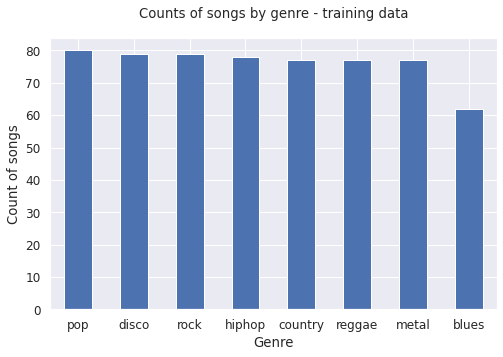

In [32]:
sns.set(font_scale=1.1)
traindf['genre'].value_counts().plot(kind='bar', rot=0, figsize=(8,5))
plt.xlabel("Genre")
plt.ylabel("Count of songs")
plt.title("Counts of songs by genre - training data", y=1.05)
plt.show()

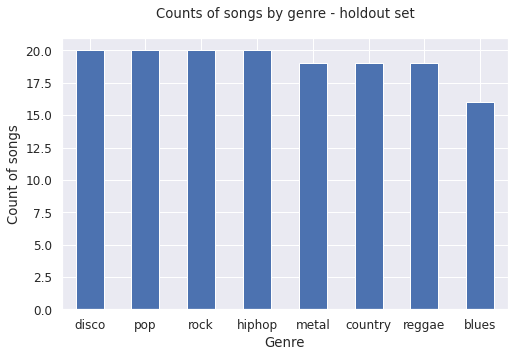

In [33]:
sns.set(font_scale=1.1)
testdf['genre'].value_counts().plot(kind='bar', rot=0, figsize=(8,5))
plt.xlabel("Genre")
plt.ylabel("Count of songs")
plt.title("Counts of songs by genre - holdout set", y=1.05)
plt.show()

In [34]:
X_train = traindf['lemmatized']
y_train = traindf['genre']#.astype("category")
X_test = testdf['lemmatized']
y_test = testdf['genre']#.astype("category")

## Try out some models

In [35]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, recall_score, precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [36]:
# encode labels for xgboost
label_enc = LabelEncoder()
label_enc = label_enc.fit(y_train)
y_train_enc = label_enc.transform(y_train)

In [37]:
def dummy_fun(doc):
    return doc

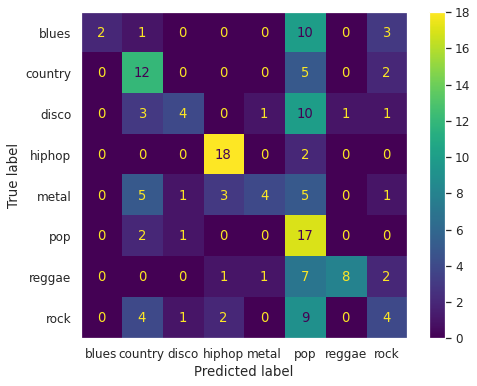

Accuracy  = 0.45098039215686275
F1 score  = 0.4283907779673622
Precision = 0.6000861883214824
Recall    = 0.45098039215686275


In [38]:
# Pipeline & Gridsearch setup
# MultinomialBayes pipeline setup
mb_pipe = Pipeline([
    ('vec', TfidfVectorizer(tokenizer=dummy_fun, preprocessor=dummy_fun)),
    ('mb', MultinomialNB())
])

# Fit
mb_pipe.fit(X_train, y_train)

evaluate_classifier(mb_pipe, X_test, y_test, LABELS)

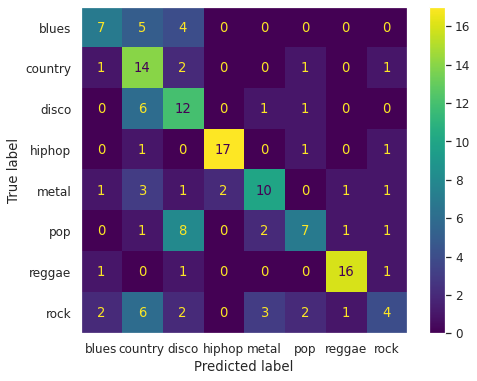

Accuracy  = 0.5686274509803921
F1 score  = 0.5610000584645615
Precision = 0.5950817949011964
Recall    = 0.5686274509803921


In [39]:
# Randomforest pipeline setup
rf_pipe = Pipeline([
    ('vec', TfidfVectorizer(tokenizer=dummy_fun, preprocessor=dummy_fun)),
    ('rf', RandomForestClassifier())
])

# Fit
rf_pipe.fit(X_train, y_train)

evaluate_classifier(rf_pipe, X_test, y_test, LABELS)

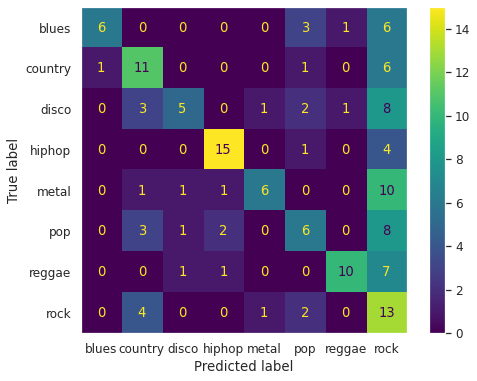

Accuracy  = 0.47058823529411764
F1 score  = 0.4900100378954185
Precision = 0.6129453667903684
Recall    = 0.47058823529411764


In [40]:
# SVM pipeline setup
svm_pipe = Pipeline([
    ('vec', TfidfVectorizer(tokenizer=dummy_fun, preprocessor=dummy_fun)),
    ('svm', SVC())
])

# Fit
svm_pipe.fit(X_train, y_train)

evaluate_classifier(svm_pipe, X_test, y_test, LABELS)

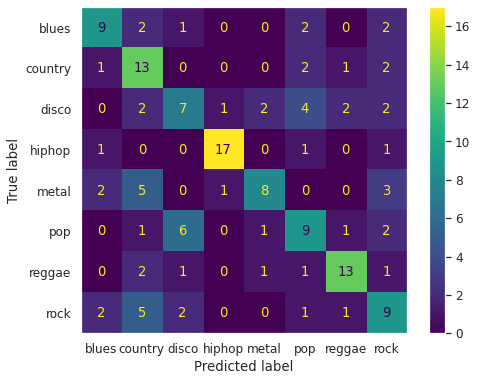

Accuracy  = 0.5555555555555556
F1 score  = 0.5562395540709447
Precision = 0.5721181134888413
Recall    = 0.5555555555555556


In [15]:
# XGBoost pipeline setup
xgb_pipe = Pipeline([
    ('vec', TfidfVectorizer(tokenizer=dummy_fun, preprocessor=dummy_fun)),
    ('xgb', XGBClassifier(objective='multi:softprob'))
    #('xgb', XGBClassifier(random_state=42, seed=2, colsample_bytree=0.6, subsample=0.7))
])

# Fit
xgb_pipe.fit(X_train, y_train_enc)

evaluate_classifier(xgb_pipe, X_test, y_test, LABELS, label_enc)

# Gridsearch to find optimal parameters

In [16]:
# SCORING = 'accuracy'
SCORING = 'balanced_accuracy'
# SCORING = 'f1_weighted'
# SCORING = 'roc_auc_ovo_weighted'

## Naive Bayes

In [17]:
# Setting params for MultinomialBayes gridsearch
mb_params = {
    'vec__tokenizer':[dummy_fun],
    'vec__preprocessor':[dummy_fun],
    'vec__max_df':[0.7, 0.8, 1.0],
    'vec__max_features':[None, 1000, 2000, 3000],
    'mb__alpha': [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100, 1000],
}

# Setting up GridSearch for MultinomialBayes
mb_gs = GridSearchCV(mb_pipe, param_grid=mb_params, cv=5, scoring=SCORING)
# Fitting MultiBayes GS
mb_gs.fit(X_train, y_train)

print("Best CV score = %0.3f with the following parameters:" % mb_gs.best_score_)
print(mb_gs.best_params_)

Best CV score = 0.506 with the following parameters:
{'mb__alpha': 0.1, 'vec__max_df': 0.7, 'vec__max_features': 2000, 'vec__preprocessor': <function dummy_fun at 0x7f5dac38d160>, 'vec__tokenizer': <function dummy_fun at 0x7f5dac38d160>}


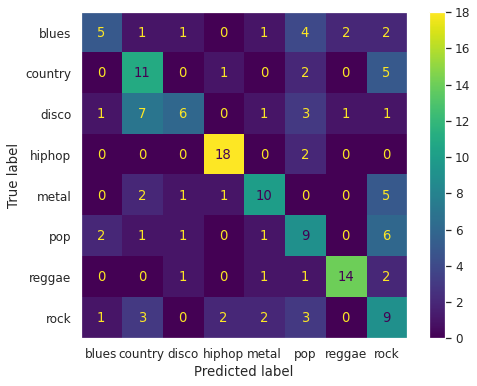

Accuracy  = 0.5359477124183006
F1 score  = 0.5363372284940913
Precision = 0.5662391116082004
Recall    = 0.5359477124183006


In [18]:
evaluate_classifier(mb_gs.best_estimator_, X_test, y_test, LABELS)

## Random forest classifier

Fitting 5 folds for each of 432 candidates, totalling 2160 fits

Best CV score = 0.588 with the following parameters:
{'rf__max_depth': None, 'rf__min_samples_split': 10, 'rf__n_estimators': 1000, 'rf__random_state': 12345, 'vec__max_df': 0.7, 'vec__max_features': 2000, 'vec__preprocessor': <function dummy_fun at 0x7f5d8aab2e50>, 'vec__tokenizer': <function dummy_fun at 0x7f5d8aab2e50>}



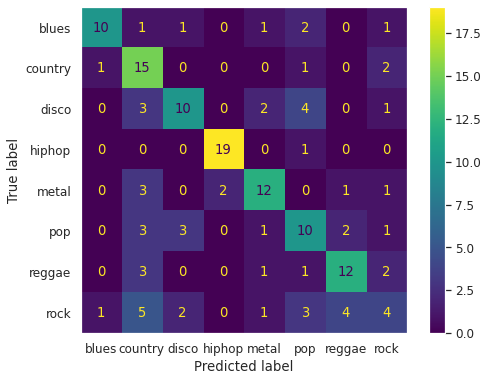

Accuracy  = 0.6013071895424836
F1 score  = 0.5940257530405785
Precision = 0.6077724018900489
Recall    = 0.6013071895424836


In [41]:
# Setting up randomforest params
rf_params = {
    'vec__tokenizer':[dummy_fun],
    'vec__preprocessor':[dummy_fun],
    'vec__max_df':[0.7, 0.8, 1.0],
    'vec__max_features':[None, 1000, 2000, 3000],
    'rf__n_estimators': [50, 100, 500, 1000],
    'rf__max_depth': [3, 10, None],
    'rf__min_samples_split': [2, 5, 10],
    'rf__random_state': [RANDOM_STATE]
}

# Setting up GridSearch for Randomforest
rf_gs = GridSearchCV(rf_pipe, param_grid=rf_params, cv=5, verbose=1, n_jobs=-1, scoring=SCORING)
# Fitting Randomforest CV GS
rf_gs.fit(X_train, y_train)

print("\nBest CV score = %0.3f with the following parameters:" % rf_gs.best_score_)
print(rf_gs.best_params_)
print("")
evaluate_classifier(rf_gs.best_estimator_, X_test, y_test, LABELS)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits

Best CV score = 0.587 with the following parameters:
{'rf__max_depth': None, 'rf__min_samples_split': 5, 'rf__n_estimators': 1000, 'vec__max_df': 1.0, 'vec__max_features': 2000, 'vec__preprocessor': <function dummy_fun at 0x7f5dac38d160>, 'vec__tokenizer': <function dummy_fun at 0x7f5dac38d160>}



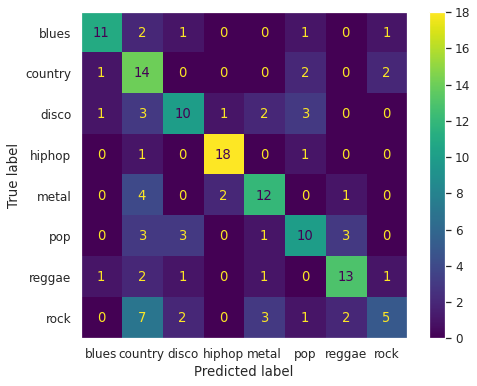

Accuracy  = 0.6078431372549019
F1 score  = 0.6026190492826087
Precision = 0.6280398869787567
Recall    = 0.6078431372549019


In [20]:
# Setting up GridSearch for Randomforest
rf_gs2 = GridSearchCV(rf_pipe, param_grid=rf_params, cv=5, verbose=1, n_jobs=-1, scoring=SCORING)
# Fitting Randomforest CV GS
rf_gs2.fit(X_train, y_train)

print("\nBest CV score = %0.3f with the following parameters:" % rf_gs2.best_score_)
print(rf_gs2.best_params_)
print("")
evaluate_classifier(rf_gs2.best_estimator_, X_test, y_test, LABELS)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits

Best CV score = 0.600 with the following parameters:
{'rf__max_depth': None, 'rf__min_samples_split': 5, 'rf__n_estimators': 1000, 'vec__max_df': 0.8, 'vec__max_features': 3000, 'vec__preprocessor': <function dummy_fun at 0x7f5dac38d160>, 'vec__tokenizer': <function dummy_fun at 0x7f5dac38d160>}



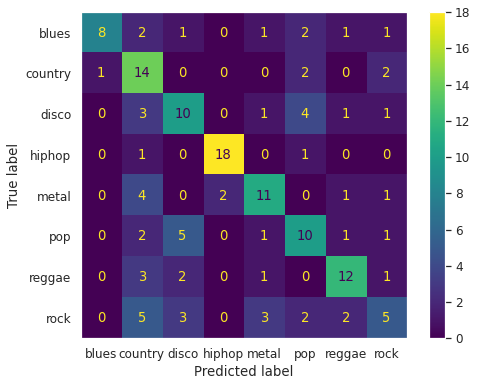

Accuracy  = 0.5751633986928104
F1 score  = 0.572951324134833
Precision = 0.5993756979916149
Recall    = 0.5751633986928104


In [21]:
# Setting up GridSearch for Randomforest
rf_gs3 = GridSearchCV(rf_pipe, param_grid=rf_params, cv=5, verbose=1, n_jobs=-1, scoring=SCORING)
# Fitting Randomforest CV GS
rf_gs3.fit(X_train, y_train)

print("\nBest CV score = %0.3f with the following parameters:" % rf_gs3.best_score_)
print(rf_gs3.best_params_)
print("")
evaluate_classifier(rf_gs3.best_estimator_, X_test, y_test, LABELS)

## Support Vector Machine

Fitting 5 folds for each of 1440 candidates, totalling 7200 fits
Best CV score = 0.501 with the following parameters:
{'svm__C': 100, 'svm__gamma': 'scale', 'svm__kernel': 'sigmoid', 'vec__max_df': 0.7, 'vec__max_features': 3000, 'vec__preprocessor': <function dummy_fun at 0x7f5dac38d160>, 'vec__tokenizer': <function dummy_fun at 0x7f5dac38d160>}



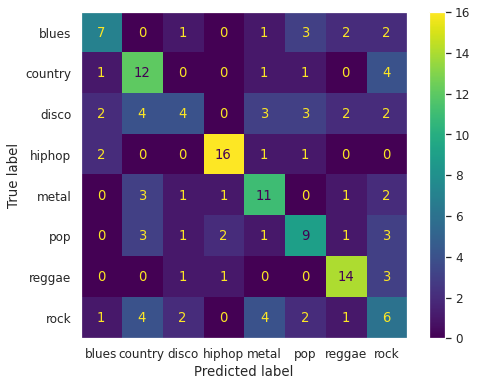

Accuracy  = 0.5163398692810458
F1 score  = 0.5073920359083374
Precision = 0.5129379850742081
Recall    = 0.5163398692810458


In [22]:
# Setting params for MultinomialBayes gridsearch
svm_params = {
    'vec__tokenizer':[dummy_fun],
    'vec__preprocessor':[dummy_fun],
    'vec__max_df':[0.7, 0.8, 1.0],
    'vec__max_features':[None, 1000, 2000, 3000],
    'svm__C': [0.1, 1, 10, 100, 1000],
    'svm__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'svm__gamma': ['auto', 'scale', 1, 0.1, 0.01, 0.001],
}

# Setting up GridSearch for MultinomialBayes
svm_gs = GridSearchCV(svm_pipe, param_grid=svm_params, cv=5, verbose=1, n_jobs=-1, scoring=SCORING)
# Fitting MultiBayes GS
svm_gs.fit(X_train, y_train)

print("Best CV score = %0.3f with the following parameters:" % svm_gs.best_score_)
print(svm_gs.best_params_)
print("")
evaluate_classifier(svm_gs.best_estimator_, X_test, y_test, LABELS)

## XGBoost

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best CV score = 0.513 with the following parameters:
{'vec__max_df': 0.7, 'vec__max_features': 2000, 'vec__preprocessor': <function dummy_fun at 0x7f5dac38d160>, 'vec__tokenizer': <function dummy_fun at 0x7f5dac38d160>, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 10, 'xgb__n_estimators': 500, 'xgb__random_state': 123, 'xgb__seed': 123}



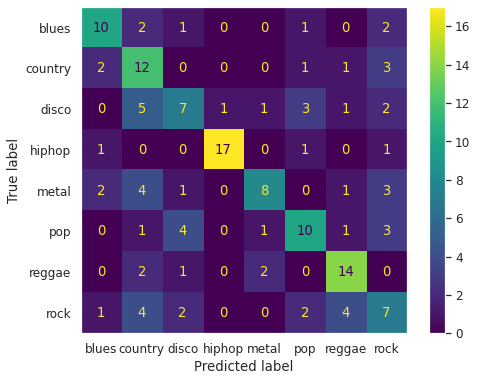

Accuracy  = 0.5555555555555556
F1 score  = 0.5563155720262748
Precision = 0.5736878589819767
Recall    = 0.5555555555555556


In [23]:
# Setting params for XGBoost gridsearch
xgb_params = {
    'vec__tokenizer':[dummy_fun],
    'vec__preprocessor':[dummy_fun],
    'vec__max_df':[0.7, 0.8, 1.0],
    'vec__max_features':[1000, 2000, 3000, None],
    'xgb__max_depth': [3, 6, 10],
    'xgb__n_estimators': [50, 100, 200, 500],
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__random_state': [123],
    'xgb__seed': [123],
}

# Setting up GridSearch for XGBoost
xgb_gs = GridSearchCV(xgb_pipe, param_grid=xgb_params, cv=5, verbose=1, n_jobs=-1, scoring=SCORING)
# Fitting MultiBayes GS
xgb_gs.fit(X_train, y_train_enc)

print("Best CV score = %0.3f with the following parameters:" % xgb_gs.best_score_)
print(xgb_gs.best_params_)
print("")
evaluate_classifier(xgb_gs.best_estimator_, X_test, y_test, LABELS, label_enc)

# Train optimal pipeline

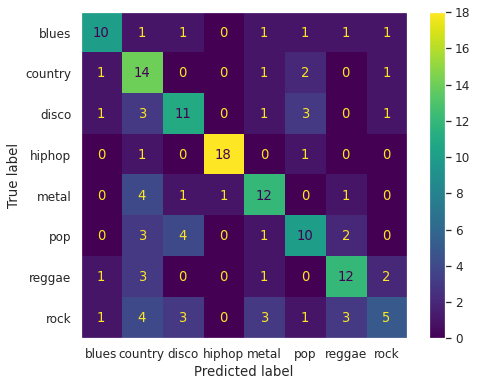

Accuracy  = 0.6013071895424836
F1 score  = 0.5963677418785778
Precision = 0.6140369739956943
Recall    = 0.6013071895424836


In [25]:
# Optimal pipeline setup
opt_pipe = Pipeline([
    ('vec', TfidfVectorizer(
        tokenizer=dummy_fun, 
        preprocessor=dummy_fun,
        max_df=0.8,
    )),
    ('rf', RandomForestClassifier(
        random_state=RANDOM_STATE,
        max_depth=None,
        min_samples_split=5,
        n_estimators=1000
    ))
])

# Fit
opt_pipe.fit(X_train, y_train)

evaluate_classifier(opt_pipe, X_test, y_test)

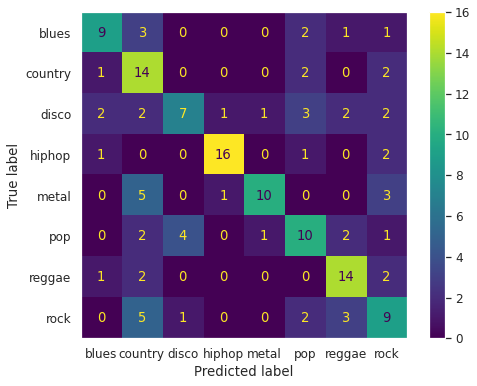

Accuracy  = 0.5816993464052288
F1 score  = 0.583189394363283
Precision = 0.6137047411557216
Recall    = 0.5816993464052288


In [26]:
# Optimal pipeline setup
opt_pipe = Pipeline([
    ('vec', TfidfVectorizer(
        tokenizer=dummy_fun, 
        preprocessor=dummy_fun,
        max_df=0.8,
    )),
    ('xgb', XGBClassifier(
        random_state=RANDOM_STATE,
        seed=RANDOM_STATE,
        max_depth=3,
        learning_rate=0.1,
        n_estimators=200
    ))
])

# Fit
opt_pipe.fit(X_train, y_train_enc)

evaluate_classifier(opt_pipe, X_test, y_test, label_encoder=label_enc)